In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# Notification age

**RQ:** How old are the notifications in the notification drawer?

In [4]:
def get_notification_age(lst, t):
    result = []
    for n in lst:
        age = t - n['postTime']
        age = max(age, 0)
        age = min(age, 1000*60*60*24*31) # 31 days
        
        result.append({
            'Key': n['key'],
            'PackageName': n['packageName'],
            'SnapshotTime': t,
            'PostTime': n['postTime'],
            'Age': age
        })
    return result

def worker_age(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    
    result = df.apply(lambda x: get_notification_age(x['Active'], x['Time']), axis=1).tolist()
    result = pd.DataFrame(list(itertools.chain(*result)))
    
    result['Age'] = pd.to_timedelta(result.Age, unit='ms')
    result['AgeSeconds'] = result.Age.dt.total_seconds()
    result['UUID'] = uuid
    
    return result

In [5]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_age, uuids)

age = pd.concat(lst)
age = age.reset_index(drop=True)
age.tail()

,Age,Key,PackageName,PostTime,SnapshotTime,AgeSeconds,UUID
40836335,00:00:05.661000,key.1437629,com.android.mms,1541774173380,1541774179041,5.661,device.3952
40836336,00:00:05.300000,key.1437637,android,1541774173741,1541774179041,5.300,device.3952
40836337,00:00:00.126000,key.1437632,com.android.systemui,1541788627043,1541788627169,0.126,device.3952
40836338,00:14:53.820000,key.1437640,com.android.server.telecom,1541789046931,1541789940751,893.820,device.3952
40836339,00:14:28.930000,key.1437629,com.android.mms,1541789071821,1541789940751,868.930,device.3952


In [6]:
len(age.UUID.unique())

3953

In [7]:
len(age)

40836340

## Stats

In [8]:
age.describe()

,Age,PostTime,SnapshotTime,AgeSeconds
count,40836340,4.083634e+07,4.083634e+07,4.083634e+07
mean,0 days 09:45:41.895442,1.543141e+12,1.543184e+12,3.514190e+04
std,1 days 10:08:06.050922,3.168722e+09,2.396121e+09,1.228861e+05
min,0 days 00:00:00,4.819900e+04,1.537169e+12,0.000000e+00
25%,0 days 00:14:44.746000,1.541274e+12,1.541306e+12,8.847460e+02
50%,0 days 01:17:58.022000,1.543184e+12,1.543223e+12,4.678022e+03
75%,0 days 05:46:22.710250,1.545342e+12,1.545384e+12,2.078271e+04
max,31 days 00:00:00,1.577720e+12,1.546879e+12,2.678400e+06


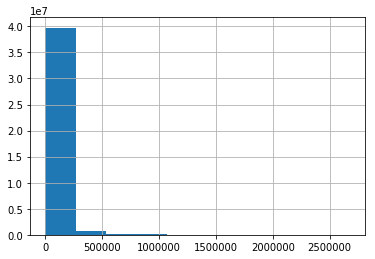

In [9]:
age.AgeSeconds.hist()

## Outliers

In [10]:
len(age[age.Age == pd.Timedelta('0 days')])

23925

In [11]:
len(age[age.Age > pd.Timedelta('180 days')])

0

In [12]:
age.AgeSeconds.quantile(.95)

154520.62934999986

## Categories

In [13]:
age['Category'] = age.PackageName.apply(lambda x: category_mapping[x] if x in category_mapping else 'UNKNOWN')
age.tail()

,Age,Key,PackageName,PostTime,SnapshotTime,AgeSeconds,UUID,Category
40836335,00:00:05.661000,key.1437629,com.android.mms,1541774173380,1541774179041,5.661,device.3952,SMS/IM
40836336,00:00:05.300000,key.1437637,android,1541774173741,1541774179041,5.300,device.3952,SYSTEM
40836337,00:00:00.126000,key.1437632,com.android.systemui,1541788627043,1541788627169,0.126,device.3952,SYSTEM
40836338,00:14:53.820000,key.1437640,com.android.server.telecom,1541789046931,1541789940751,893.820,device.3952,PHONE
40836339,00:14:28.930000,key.1437629,com.android.mms,1541789071821,1541789940751,868.930,device.3952,SMS/IM


In [14]:
age2 = age[['UUID', 'Category', 'AgeSeconds']].copy()
age2.tail()

,UUID,Category,AgeSeconds
40836335,device.3952,SMS/IM,5.661
40836336,device.3952,SYSTEM,5.300
40836337,device.3952,SYSTEM,0.126
40836338,device.3952,PHONE,893.820
40836339,device.3952,SMS/IM,868.930


In [15]:
age2 = age2.groupby(['UUID', 'Category'], as_index=False).median()
del age2['UUID']

age2.tail()

,Category,AgeSeconds
40620,PHONE,734.5025
40621,SMS/IM,1753.0390
40622,SYSTEM,13272.4225
40623,TOOL,1014.9860
40624,UNKNOWN,1197.0350


In [16]:
age2.groupby('Category').describe().T

Category          CALENDAR/REMINDER          EMAIL           GAME  \
AgeSeconds count        3052.000000    2523.000000    1967.000000   
           mean         3031.329836    4697.855919    5367.550739   
           std         25145.025312    8862.743137   11608.508460   
           min             0.031000       0.212000       0.000000   
           25%            54.068375    1132.525750    1106.088500   
           50%           622.366750    2473.118500    2697.606500   
           75%          1731.361500    5087.043250    6021.752750   
           max        920432.663000  167149.717500  198319.305500   

Category          HEALTH/FITNESS          MEDIA     NAVIGATION           NEWS  \
AgeSeconds count      784.000000    3710.000000    2512.000000    1733.000000   
           mean      5228.797951    5469.714729    3422.660741    4970.461455   
           std      12090.948545   16681.231703   13432.892570   11383.772006   
           min          0.154000       0.129000       0.000000       0.000000   
           25%       1093.557000     231.215875     583.274250     901.805000   
           50%       2378.687500    1266.123250     960.980250    1893.802500   
           75%       5006.702750    4195.075250    1869.139375    4902.265500   
           max     169017.856000  344637.836500  374638.332000  190277.217000   

Category                  PHONE       SHOPPING         SMS/IM         SOCIAL  \
AgeSeconds count    3857.000000    2025.000000    3930.000000    3552.000000   
           mean     3827.719835    5341.710222    2205.855727    5428.226929   
           std     23139.700371   18773.003820    4705.884096   11211.118681   
           min         0.000000       0.067000       0.179000       0.019000   
           25%        39.356000     871.485000     659.674625    1266.260625   
           50%       345.363000    2116.733000    1202.889250    2887.490500   
           75%      1473.962000    4763.145000    2293.414750    5466.432250   
           max    698332.207000  662709.446000  173964.882500  213116.977000   

Category                SYSTEM          TOOL       UNKNOWN  
AgeSeconds count  3.953000e+03  3.814000e+03  3.213000e+03  
           mean   9.443123e+03  9.642447e+03  1.119088e+04  
           std    5.024519e+04  5.353784e+04  5.054251e+04  
           min    1.210000e-01  0.000000e+00  0.000000e+00  
           25%    7.963670e+02  1.063172e+03  8.377970e+02  
           50%    2.782459e+03  1.993542e+03  2.562249e+03  
           75%    6.898933e+03  5.812530e+03  7.215944e+03  
           max    2.364291e+06  2.110900e+06  1.892665e+06

## Plot

In [17]:
# Rename specific categories
age2.Category = age2.Category.apply(str.title)
age2.Category = age2.Category.replace({
    'Shopping': 'Shopping &\nFinance',
    'Calendar/Reminder': 'Calendar &\nReminder',
    'Health/Fitness': 'Health &\nFitness',
    'Sms/Im': 'SmS & IM', # Lowercase "m" to fix the sorting
    'Unknown': 'Uncategorized',
    'Social': 'Social &\nDating',
    'None': 'No notification\nshown',
    'News': 'News &\nWeather'
})

In [18]:
age2.AgeSeconds = age2.AgeSeconds.apply(lambda x: x / (60*60))

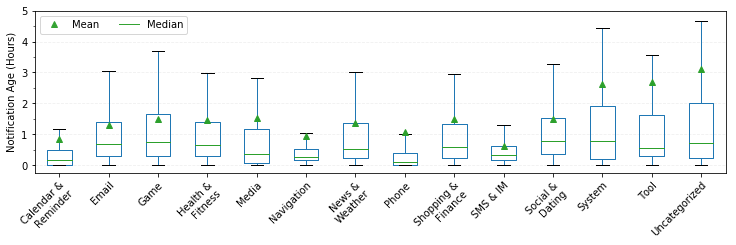

In [19]:
ax = age2.boxplot(
    by='Category',
    showfliers=False,
    showmeans=True,
    figsize=(12, 3),
)

# Dirty hack to fix the sorting
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[9] = 'SMS & IM'
ax.set_xticklabels(labels)

# Ticks
ax.set_yticks(np.arange(0, 5.1, 1.0))
ax.set_yticks(np.arange(0, 5, 0.5), minor=True)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.0, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Notification Age (Hours)', fontsize=10)
ax.tick_params(labelsize=10)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[
    mlines.Line2D([], [], color='#34a333', marker='^', linestyle='None'),
    mlines.Line2D([], [], color='#34a333', linewidth=1)
], labels=[
    'Mean',
    'Median'
], loc='upper left', ncol=2, prop={'size': 10})

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Remove automatic title
plt.title('')
plt.suptitle('')

plt.savefig('figures/category_ages.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/category_ages.pdf', bbox_inches='tight', pad_inches=0)

plt.show()